In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import torch_geometric as pyg
import numpy as np
import pandas as pd
import torch_geometric as pyg
import torch.nn.functional as F
import hydra
from hydra.core.global_hydra import GlobalHydra
import os
import wandb
import omegaconf
from pathlib import Path
os.environ["HYDRA_FULL_ERROR"] = "1"


from mil.data.mnist import MNISTBags, OneHotMNISTBags, MNISTCollage, OneHotMNISTCollage
from mil.utils import device, human_format, set_seed
from mil.utils.visualize import print_one_hot_bag_with_attention, print_one_hot_bag, plot_attention_head, plot_bag, plot_one_hot_collage
from mil.utils.stats import print_prediction_stats
from mil.models.abmil import WeightedAverageAttention
from mil.models.self_attention import MultiHeadSelfAttention
from mil.models.distance_aware_self_attention import DistanceAwareSelfAttentionHead
from mil.utils.layers import find_submodule

WANDB_ENTITY = "georgw7777"
WANDB_PROJECT = "mil"
RUN_ID = "gagfy7s7"

# Load run configuration
api = wandb.Api()
run = api.run(f"{WANDB_ENTITY}/{WANDB_PROJECT}/{RUN_ID}")
cfg = omegaconf.DictConfig(run.config)
cfg.wandb_id = RUN_ID
cfg.seed = cfg.get("seed", 0)

set_seed(cfg.seed)

/Users/georg/Projects/mil/mil_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_ds = hydra.utils.instantiate(cfg.dataset.train)
test_ds =  hydra.utils.instantiate(cfg.dataset.test)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=lambda x: x[0], num_workers=0, pin_memory=False)

In [3]:
model = hydra.utils.instantiate(cfg.model, _convert_="partial")
model.load_state_dict(torch.load(Path("checkpoints") / RUN_ID / "model_latest.pt"))
model.eval()

DistanceAwareSelfAttentionHead.SAVE_INTERMEDIATE = True
attention_layer = find_submodule(model, DistanceAwareSelfAttentionHead)

<Figure size 640x480 with 0 Axes>

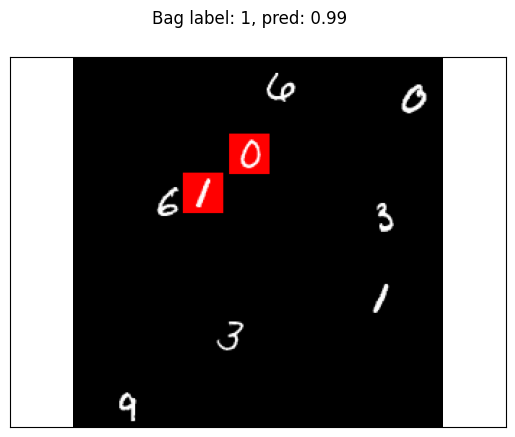

In [4]:
bag = test_ds[20]
y_pred, _ = model(bag)
plt.figure()
_ = plot_bag(bag, y_pred=y_pred, collage_size=test_ds.collage_size)

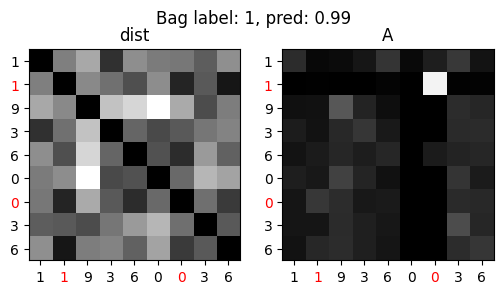

In [5]:
def plot_dist_aware_attention(bag, model, attention_layer):
    y_pred, _ = model(bag)
    plt.figure(figsize=(6, 3))
    plt.suptitle(f"Bag label: {bag.y.item():.0f}, pred: {y_pred.item():.2f}")
    plt.subplot(121)
    plt.title("dist")
    dist = pyg.utils.to_dense_adj(bag.edge_index, edge_attr=bag.edge_attr.squeeze(-1), max_num_nodes=bag.num_nodes).squeeze(0)  # NxN
    plot_attention_head(bag, dist, limit_range=False)
    plt.subplot(122)
    plt.title("A")
    plot_attention_head(bag, attention_layer.A)

plot_dist_aware_attention(bag, model, attention_layer)

In [6]:
from train import test, History

loss_function = hydra.utils.instantiate(cfg.loss)
history = History()

predictions = test(cfg, model, loss_function, test_loader, history, save_predictions=True)
print_prediction_stats(predictions, target_numbers=cfg.settings.mnist.target_numbers)

Testing: 100%|██████████| 100/100 [00:00<00:00, 304.04it/s]



                                 % acc    total    -pred    +pred     example
  bags                              92      100       54       46     0 7 4 8 8 1 9 2 5
  bags with 0s                      89       78       32       46     0 7 4 8 8 1 9 2 5
  bags without 0s                  100       22       22        0     5 7 5 6 8 6 8 2 7 9
  bags with 0s and 1s               90       65       21       44     0 7 4 8 8 1 9 2 5
  bags with 0s and not 1s           84       13       11        2     9 3 2 5 3 3 4 5 0 6 0
  bags with 1s                      92       77       33       44     0 7 4 8 8 1 9 2 5
  bags without 1s                   91       23       21        2     5 7 5 6 8 6 8 2 7 9
  bags with 1s and 0s               90       65       21       44     0 7 4 8 8 1 9 2 5
  bags with 1s and not 0s          100       12       12        0     3 4 7 1 4 6
  bags with 2 key instance(s)       87       48        6       42     0 1 4 5 4 7 6 7 2
  bags with 3 key instance(s)      100 

### First 10 bags in test dataset

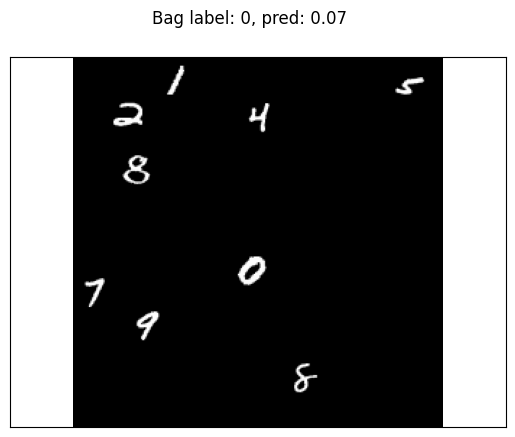

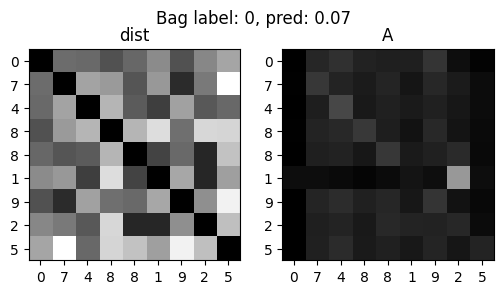

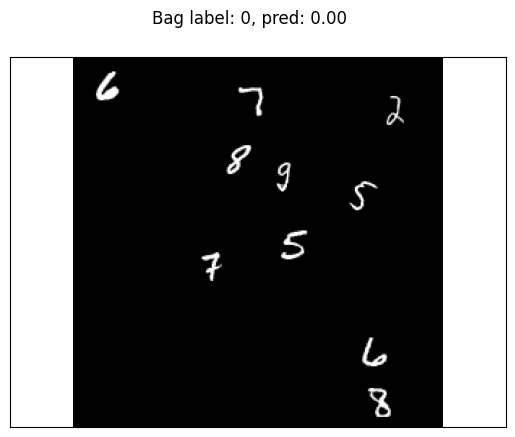

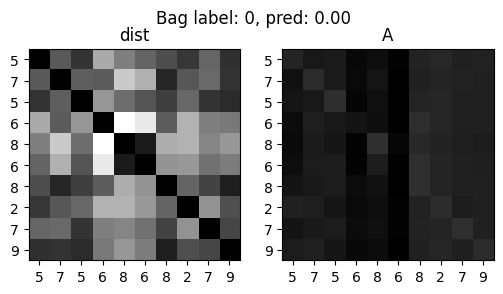

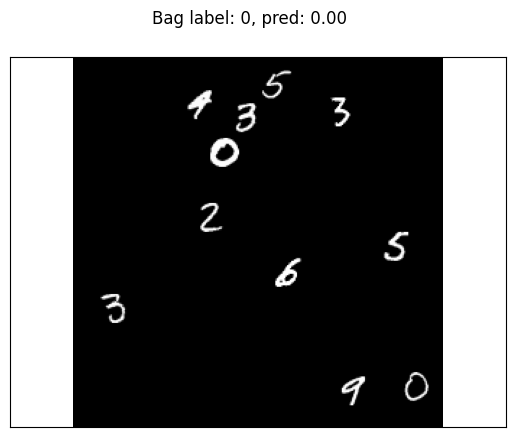

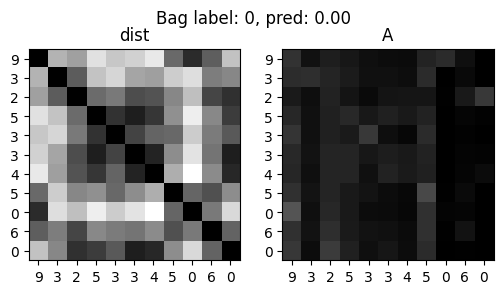

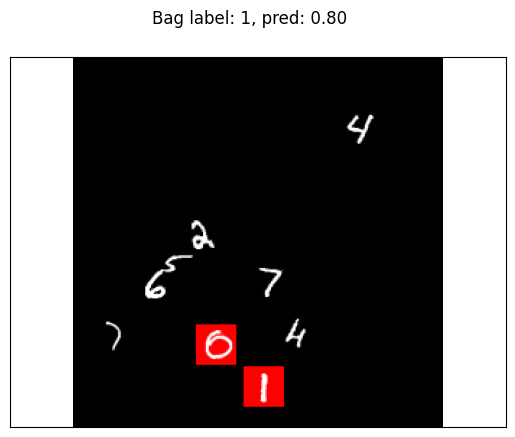

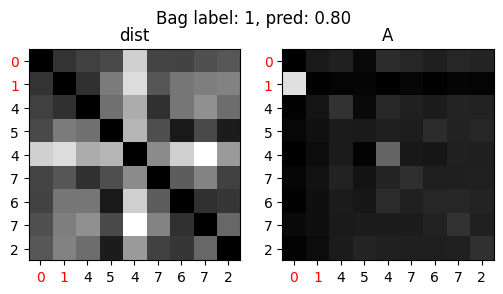

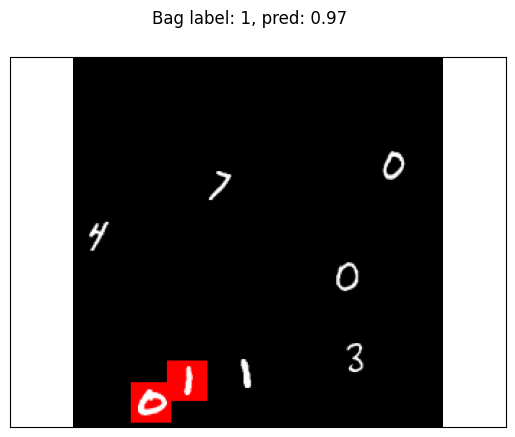

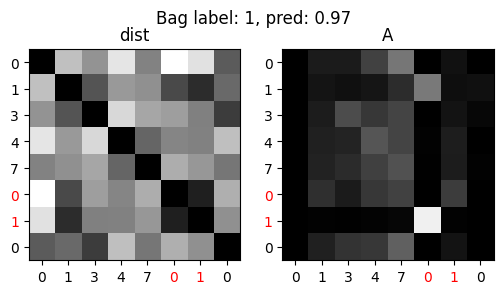

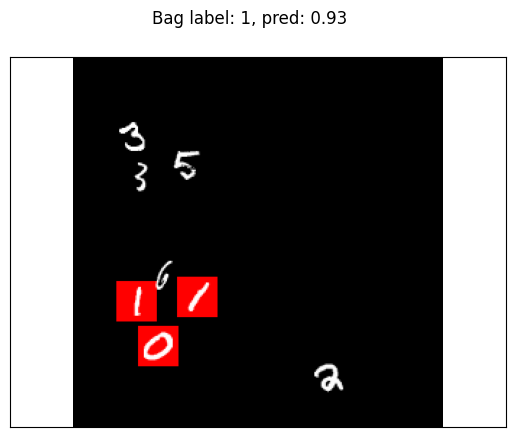

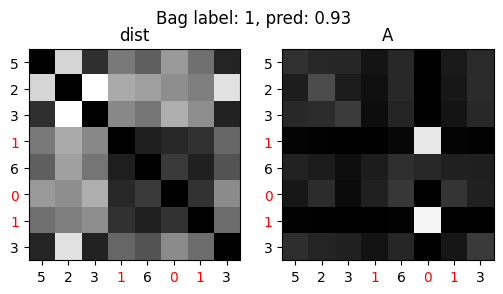

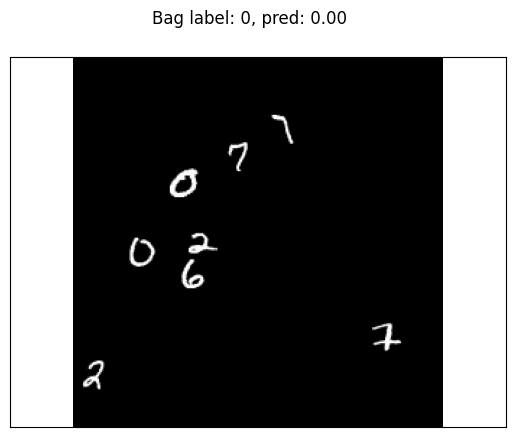

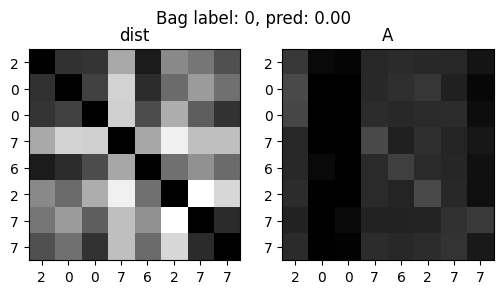

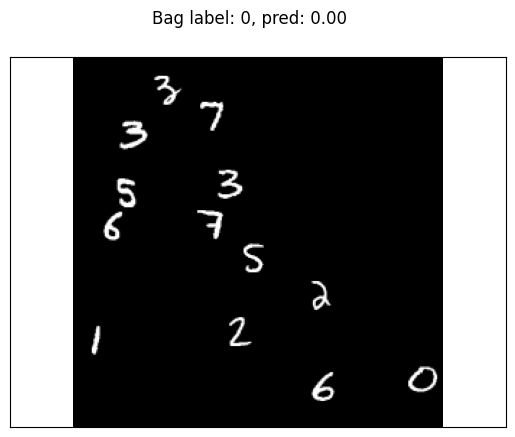

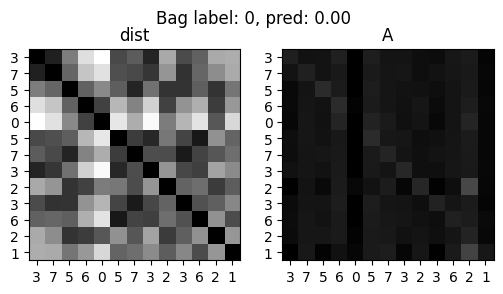

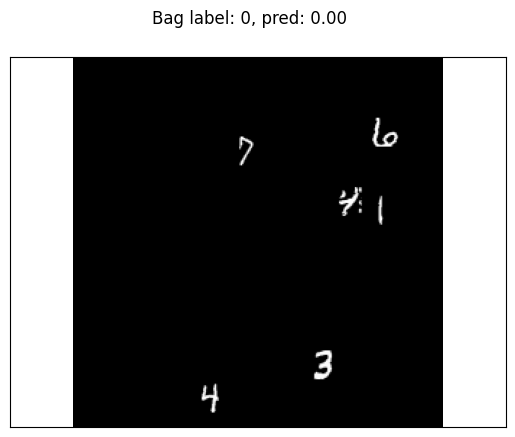

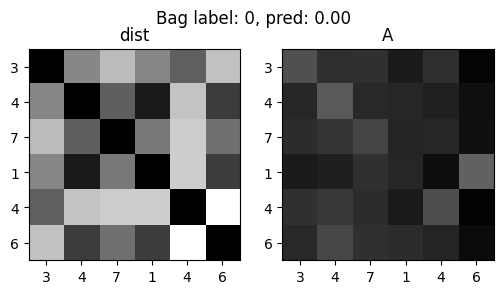

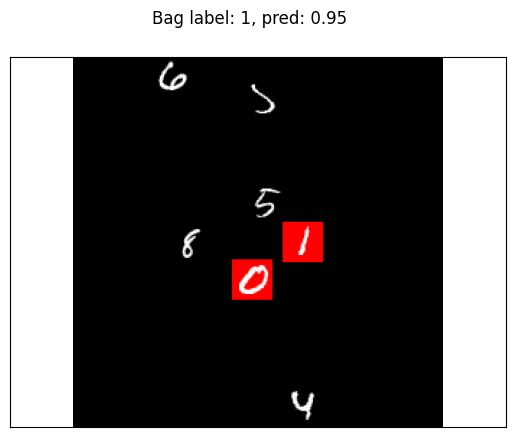

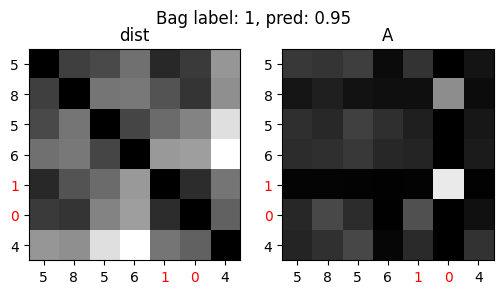

In [7]:
def visualize_prediction(bag, y_pred):
    plot_bag(bag, y_pred=y_pred, collage_size=test_ds.collage_size)
    plot_dist_aware_attention(bag, model, attention_layer)

# Visualize first 10 bags
model.eval()
with torch.no_grad():
    for bag in itertools.islice(test_loader, 10):
        bag = device(bag)
        y = bag.y.float()
        y_pred, _ = model(bag)
        visualize_prediction(bag, y_pred)

### First 10 mistakes in test dataset

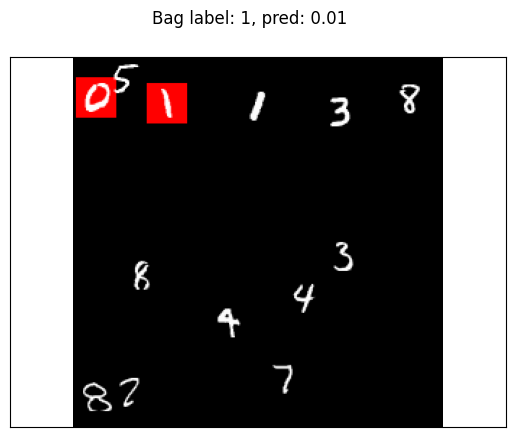

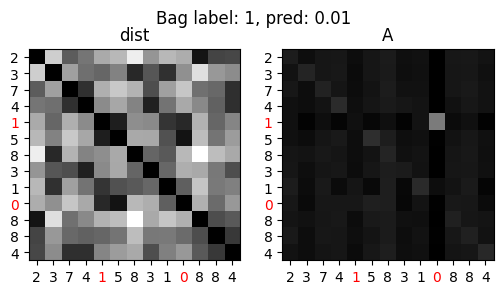

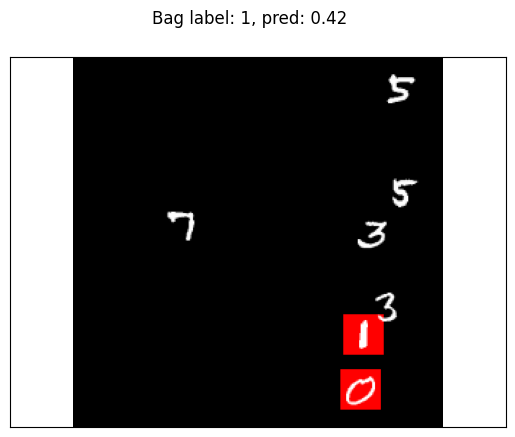

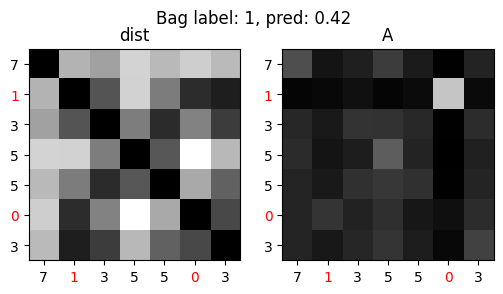

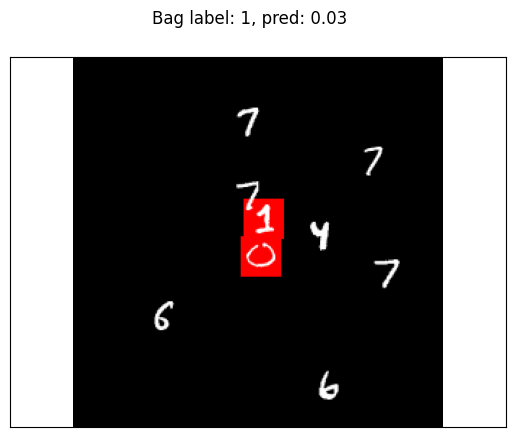

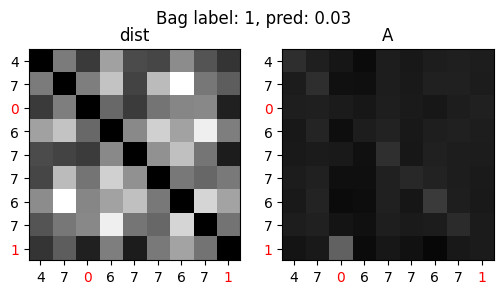

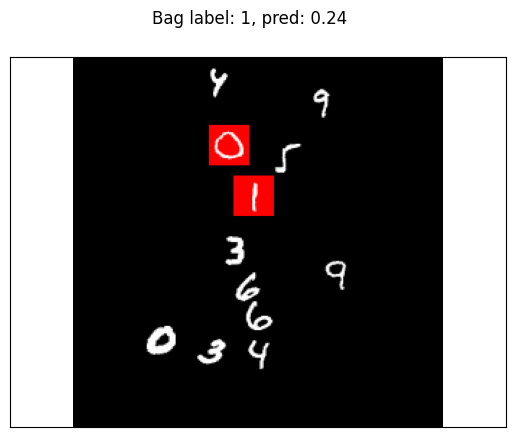

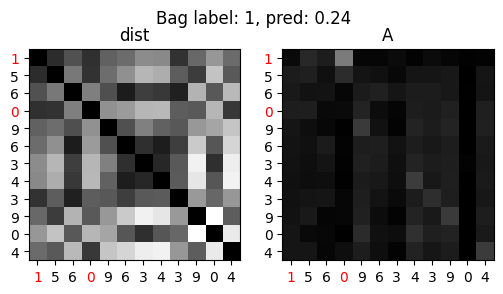

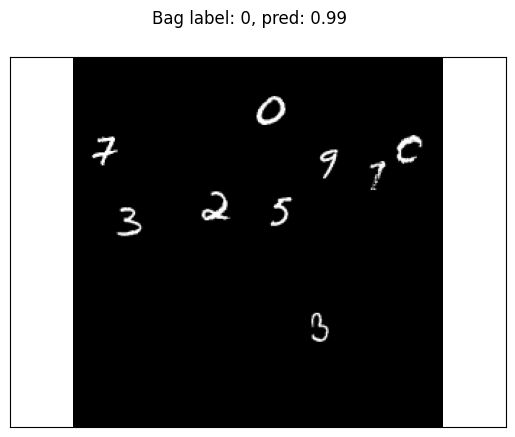

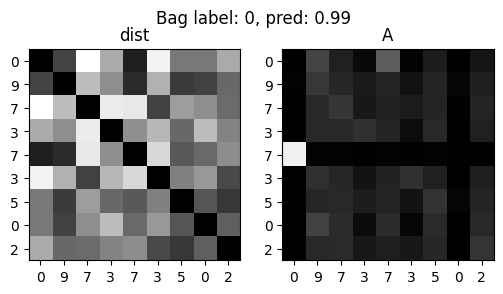

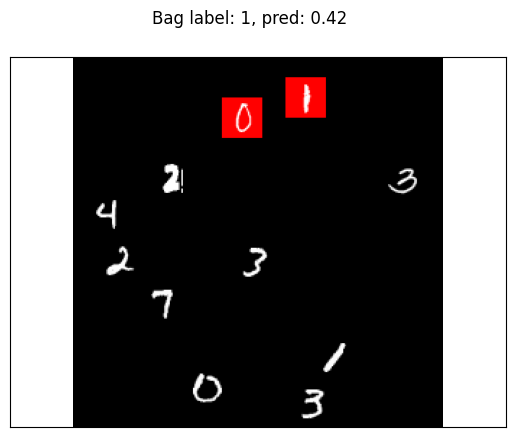

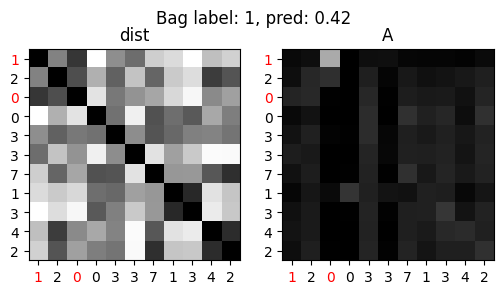

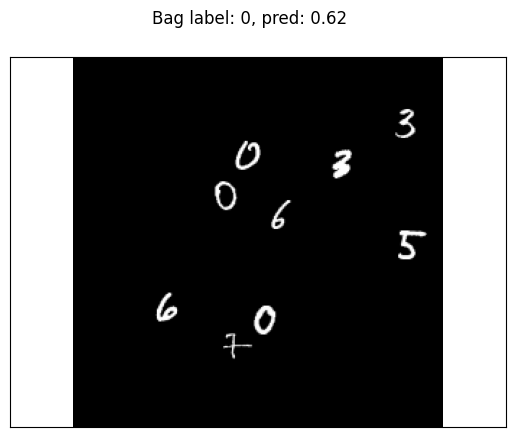

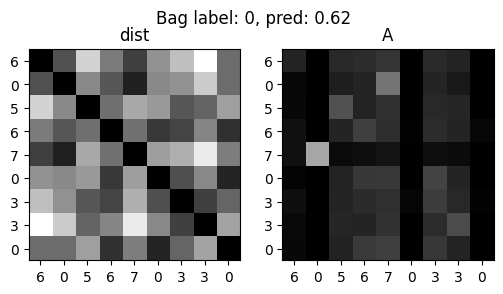

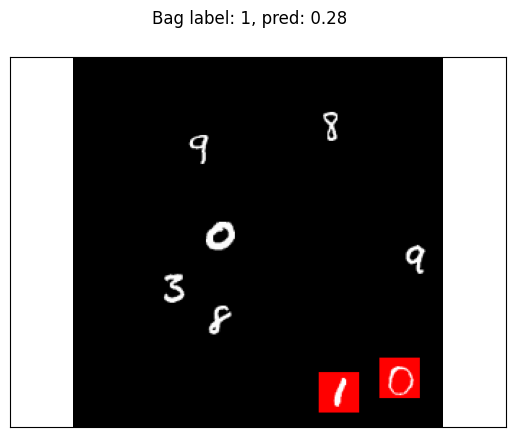

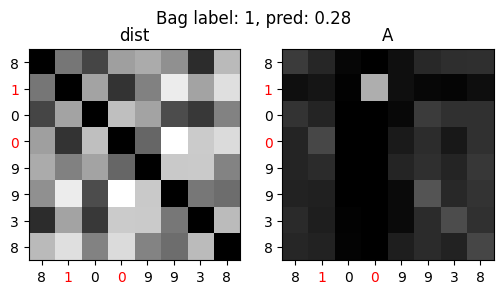

In [8]:
# Visualize first 10 mistakes
model.eval()
with torch.no_grad():
    i = 0
    for bag in test_loader:
        if i == 10:
            break
        y = bag.y.float()
        y_pred, _ = model(bag)
        if ((y_pred > .5).float() != y).cpu().detach():
            visualize_prediction(bag, y_pred)
            i += 1